# Сборный Проект — 2. HR-аналитика

**Описание проекта**. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

---

**Цель исследования** Исследование уровня удовлетворённости сотрудника, чтобы предсказать отток сотрудников.

---

**Задачи исследования**

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

---

**Исходные данные**  

Тренировочная выборка: `train_job_satisfaction_rate.csv`

Входные признаки тестовой выборки: `test_features.csv`

Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

- **id** — уникальный идентификатор сотрудника;
- **dept** — отдел, в котором работает сотрудник;
- **level** — уровень занимаемой должности;
- **workload** — уровень загруженности сотрудника;
- **employment_years** — длительность работы в компании (в годах);
- **last_year_promo** — показывает, было ли повышение за последний год;
- **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
- **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
- **salary** — ежемесячная зарплата сотрудника;
- **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install phik -q

In [2]:
#Подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik

#from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder 
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

# загружаем метод оценки важности признаков в машинном обучении
from sklearn.inspection import permutation_importance


from phik.report import plot_correlation_matrix
from phik import report

from scipy import stats as st
from scipy.stats import binom, poisson

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [3]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test = pd.read_csv('/datasets/test_features.csv')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

### Предобработка данных

In [4]:
# В целях оптимизации, напишем функцию для получения общей информации о датасете
def describe_df(df, name):
    print('размер датафрейма', name, ':', df.shape)
    print('_'*125)
    
    print('Первые 5 строк датафрейма', name)
    display(df.head())
    print('_'*125)
    
    print('Последнии 5 строк датафрейма', name)
    display(df.tail())
    print('_'*125)
    
    print('Информация о датафрейме', name)
    df.info()
    print('_'*125)
        
    print('Описание датафрейма', name)
    display(df.describe().T)
    print('_'*125)
    
    print('Количество явных дубликатов в датафрейте', name, ':', df.duplicated().sum())
    print('Количество пропусков в датафрейте', name, ':', '\n', df.isna().sum())
    
    print('*'*125)

In [5]:
#Вызовем функцию для датасета 'train'
describe_df(train, 'train')

размер датафрейма train : (4000, 10)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма train


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма train


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48
3999,338347,technology,middle,medium,5,no,yes,1,44400,0.18


_____________________________________________________________________________________________________________________________
Информация о датафрейме train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
_________________________________________________

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте train : 0
Количество пропусков в датафрейте train : 
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
*****************************************************************************************************************************


**Вывод** по общей информации в датафрейте train:

- Явные дубликаты не обнаружены
- Типы столбцов указаны верно
- Название столбцов корректны
- Обнаружены пропущенные значения, заполним их в пайплайне на следующем этапе. 

In [6]:
#Вызовем функцию для датасета 'X_test'
describe_df(X_test, 'X_test')

размер датафрейма X_test : (2000, 9)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма X_test


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма X_test


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400


_____________________________________________________________________________________________________________________________
Информация о датафрейме X_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
____________________________________________________________________________________________________________________________

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте X_test : 0
Количество пропусков в датафрейте X_test : 
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
*****************************************************************************************************************************


**Вывод** по общей информации в датафрейте X_test:

- Явные дубликаты не обнаружены
- Типы столбцов указаны верно
- Название столбцов корректны
- Обнаружены пропущенные значения, заполним их в пайплайне на следующем этапе. 

In [7]:
#Вызовем функцию для датасета 'y_test'
describe_df(y_test, 'y_test')

размер датафрейма y_test : (2000, 2)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма y_test


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма y_test


,id,job_satisfaction_rate
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26
1999,648995,0.62


_____________________________________________________________________________________________________________________________
Информация о датафрейме y_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
_____________________________________________________________________________________________________________________________
Описание датафрейма y_test


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте y_test : 0
Количество пропусков в датафрейте y_test : 
 id                       0
job_satisfaction_rate    0
dtype: int64
*****************************************************************************************************************************


#### Вывод по предобработке данных

Данные в таблицах реалистичны и соответствуют описанию. В тренировочной выборке 4000  строк, в тестовой 2000. 

На этапе предобработке данных проверили, что в данных:

- нет дубликатов
- типы столбцов указаны верно
- Название столбцов корректны
- Обнаружены пропущенные значения, заполним их в пайплайне на следующем этапе. 

### Исследовательский анализ данных

In [8]:
# В целях оптимизации, напишем функцию для получения общей информации о столбце
def describe_column(df, column):
    print('Количество строк',  ':', df[column].shape[0])
    print('_'*125)
        
    print('Описание данных')
    display(df[column].describe().T)
    print('_'*125)
    
    print('Количество уникальных значений:', df[column].unique().shape[0])
    print('Количество пропусков в датафрейте', df[column].isna().sum())
    print('_'*125)
    
    if type(df[column].loc[1]) == str:
        print('Уникальные значения')
        print(df[column].value_counts())
    
    print('*'*125)

In [9]:
# Напишем функцию построения гистограммы и диграммы размаха для количественных данных
def hix_box_plot(df, column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    
    df[column].plot(ax=ax[0], kind='hist')
     
    sns.boxplot(df[column], ax=ax[1])
    
    ax[0].set_title('Гистограмма')
    ax[0].set_xlabel(column)
    
    ax[1].set_title('Диграмма размаха')
    ax[1].set_xlabel(column)

In [10]:
# Напишем функцию построения графика для категориальных данных

def bar_pie_plot(df, column):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    
    df.groupby(column)[column].count().plot(ax=ax[0], kind='bar')
    
    df.groupby(column)[column].count().plot(ax=ax[1], kind='pie', autopct='%1.0f%%')
    
        
    ax[0].set_title(f'Количественная диограмма')
    ax[1].set_title(f'Круговая диограмма')
    
    
    ax[0].tick_params(axis='x', labelrotation=0, labelsize = 15) 
    ax[1].set_ylabel('')

Исследовательский анализ данных проведем параллельно для всех данных 

#### id — уникальный идентификатор сотрудника

In [11]:
#Для датасета train
train['id'].unique().shape[0]

4000

In [12]:
#Для датасета X_test
X_test['id'].unique().shape[0]

2000

**Вывод.** Все id уникальны.

#### dept — отдел, в котором работает сотрудник

In [13]:
#Выведем общую информацую для датасета train
describe_column(train,'dept')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count      3994
unique        5
top       sales
freq       1512
Name: dept, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 6
Количество пропусков в датафрейте 6
_____________________________________________________________________________________________________________________________
Уникальные значения
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64
*****************************************************************************************************************************


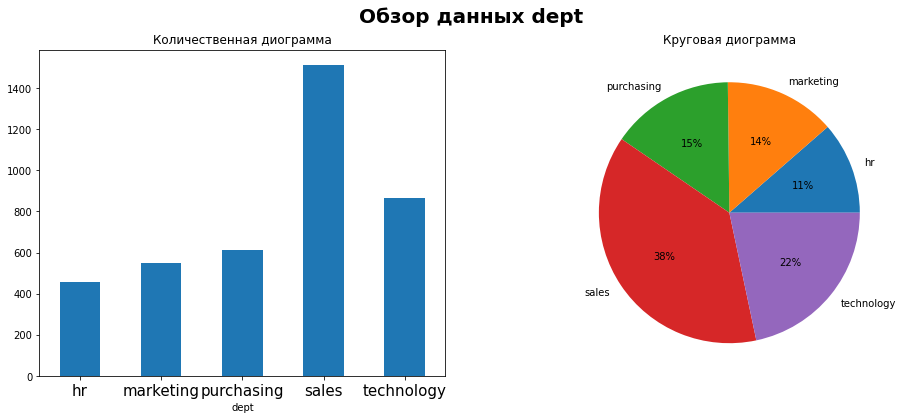

In [14]:
#Построим график для датасета train
bar_pie_plot(train, 'dept')

In [15]:
#Выведем общую информацую для датасета X_test
describe_column(X_test,'dept')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count      1998
unique        6
top       sales
freq        763
Name: dept, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 7
Количество пропусков в датафрейте 2
_____________________________________________________________________________________________________________________________
Уникальные значения
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64
*****************************************************************************************************************************


Видим, что появилось неожиданное значение ' ', заменим его на NaN

In [16]:
X_test['dept'] = X_test['dept'].replace(' ', np.nan)
print('Количество пропусков в датафрейте', X_test['dept'].isna().sum())
X_test['dept'].value_counts()

Количество пропусков в датафрейте 3


sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64

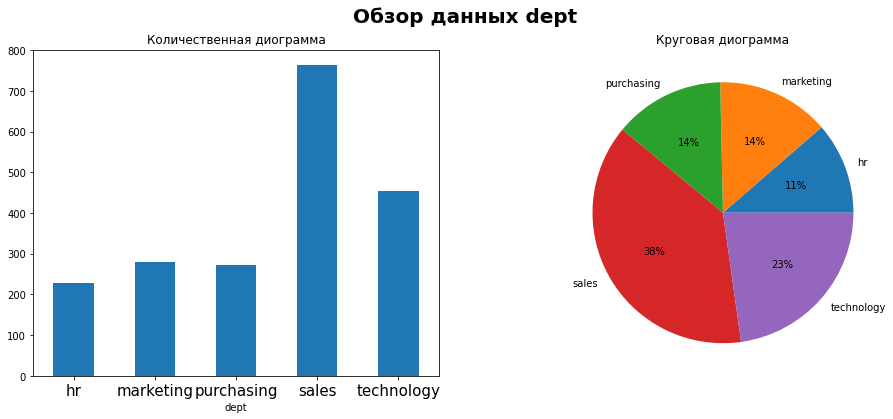

In [17]:
#Построим график для датасета train
bar_pie_plot(X_test, 'dept')

**Вывод** В столбце dept — отдел, в котором работает сотрудник. В обеих таблицах есть пропуски, обработаем их на этапе работы с пайплайнами.

В таблице X_test В столбце dept заменили " " на NaN

#### level — уровень занимаемой должности

In [18]:
#Выведем общую информацую для датасета train
describe_column(train,'level')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count       3996
unique         3
top       junior
freq        1894
Name: level, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 4
Количество пропусков в датафрейте 4
_____________________________________________________________________________________________________________________________
Уникальные значения
junior    1894
middle    1744
sinior     358
Name: level, dtype: int64
*****************************************************************************************************************************


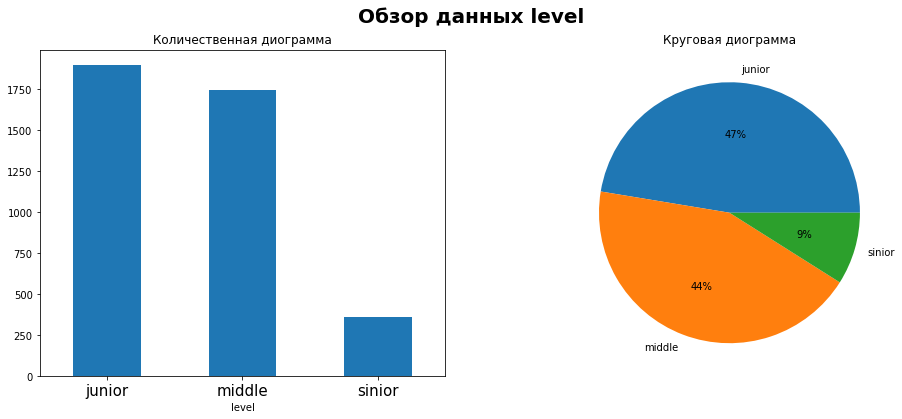

In [19]:
#Построим график для датасета train
bar_pie_plot(train, 'level')

In [20]:
#Выведем общую информацую для датасета X_test
describe_column(X_test,'level')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count       1999
unique         3
top       junior
freq         974
Name: level, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 4
Количество пропусков в датафрейте 1
_____________________________________________________________________________________________________________________________
Уникальные значения
junior    974
middle    854
sinior    171
Name: level, dtype: int64
*****************************************************************************************************************************


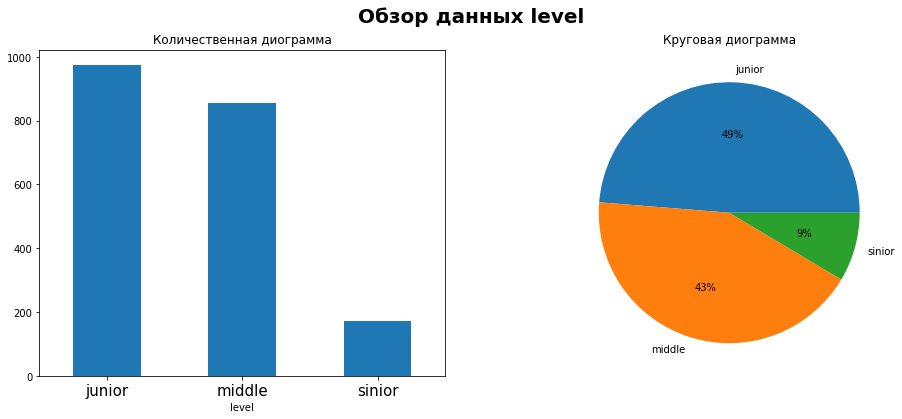

In [21]:
#Построим график для датасета X_test
bar_pie_plot(X_test, 'level')

In [22]:
# Заменим опечатку в senior
train['level'] = train['level'].replace('sinior', 'senior')
X_test['level'] = X_test['level'].replace('sinior', 'senior')

**Вывод** Исправили опечатку, заменили senior на senior. В столбце level — уровень занимаемой должности. В обеих таблицах есть пропуски, обработаем их на этапе работы с пайплайнами.

#### workload — уровень загруженности сотрудника

In [23]:
#Выведем общую информацую для датасета train
describe_column(train,'workload')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count       4000
unique         3
top       medium
freq        2066
Name: workload, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 3
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
medium    2066
low       1200
high       734
Name: workload, dtype: int64
*****************************************************************************************************************************


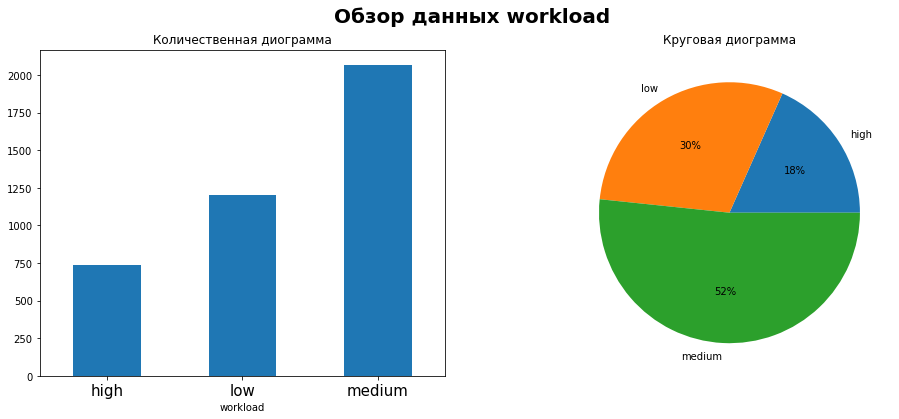

In [24]:
#Построим график для датасета train
bar_pie_plot(train, 'workload')

In [25]:
#Выведем общую информацую для датасета X_test
describe_column(X_test,'workload')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count       2000
unique         4
top       medium
freq        1043
Name: workload, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 4
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
medium    1043
low        593
high       363
             1
Name: workload, dtype: int64
*****************************************************************************************************************************


Видим, что появилось неожиданное значение ' ', заменим его на NaN

In [26]:
X_test['workload'] = X_test['workload'].replace(' ', np.nan)
print('Количество пропусков в датафрейте', X_test['workload'].isna().sum())
X_test['workload'].value_counts()

Количество пропусков в датафрейте 1


medium    1043
low        593
high       363
Name: workload, dtype: int64

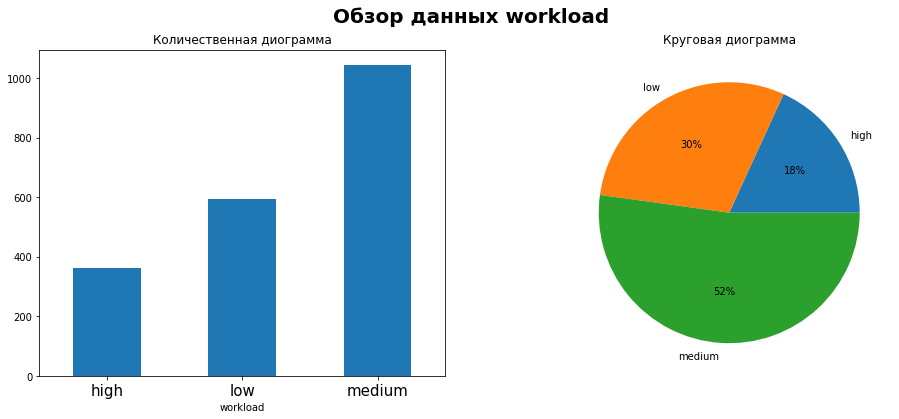

In [27]:
#Построим график для датасета X_test
bar_pie_plot(X_test, 'workload')

**Вывод** В столбце  workload — уровень загруженности сотрудника в таблице X_test заменили неожиданное значение ' ' на NaN, в результате появился пропуск, который обработаем на этапе работы с пайплайнами.

#### employment_years — длительность работы в компании (в годах)

In [28]:
#Выведем общую информацую для датасета train
describe_column(train,'employment_years')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 10
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


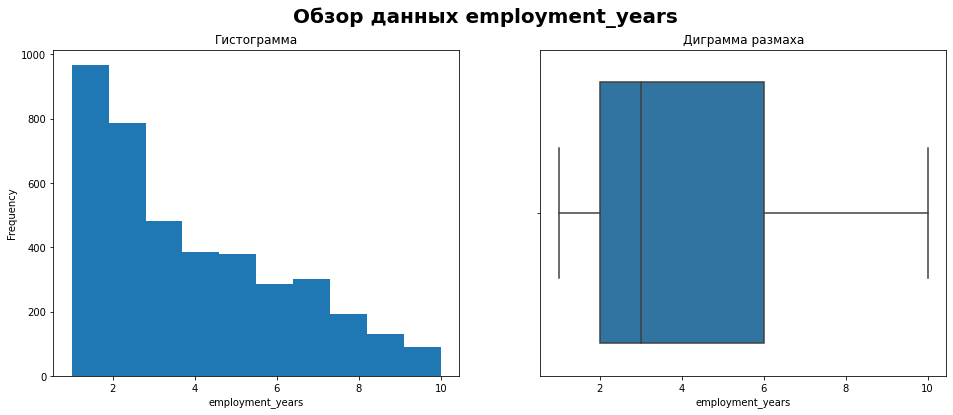

In [29]:
#Построим графики для датасета train
hix_box_plot(train,'employment_years')

In [30]:
#Выведем общую информацую для датасета X_test
describe_column(X_test,'employment_years')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 10
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


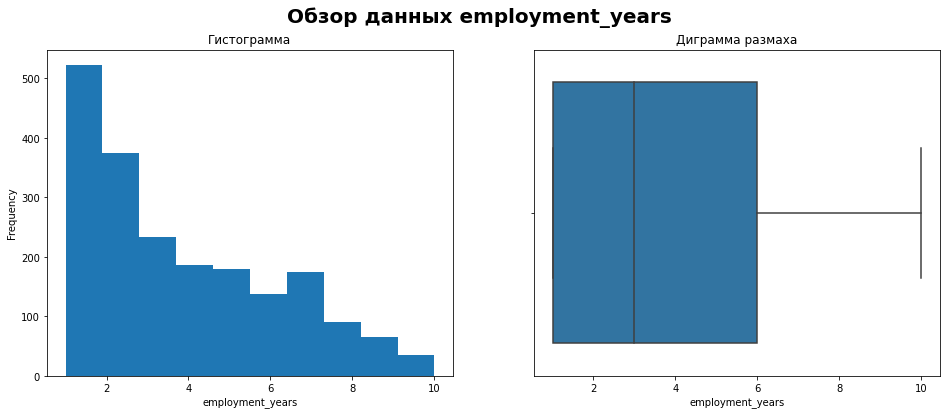

In [31]:
#Построим графики для датасета X_test
hix_box_plot(X_test,'employment_years')

#### last_year_promo — показывает, было ли повышение за последний год

In [32]:
#Выведем общую информацую для датасета train
describe_column(train,'last_year_promo')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
no     3880
yes     120
Name: last_year_promo, dtype: int64
*****************************************************************************************************************************


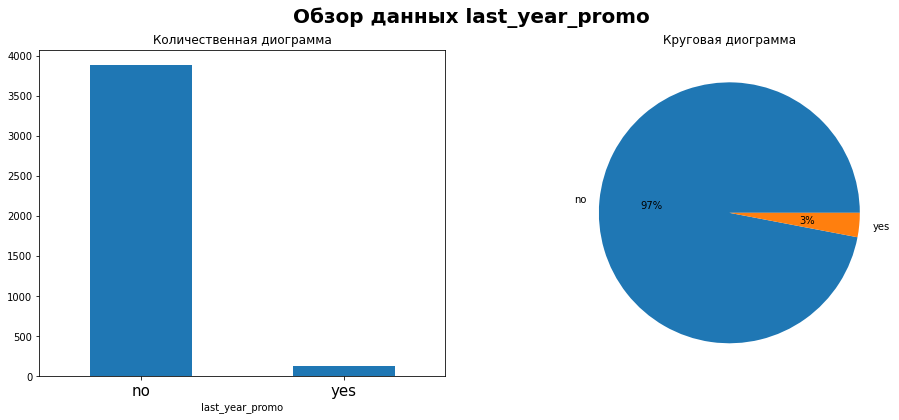

In [33]:
#Построим график для датасета train
bar_pie_plot(train, 'last_year_promo')

In [34]:
#Выведем общую информацую для датасета X_test
describe_column(X_test,'last_year_promo')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
no     1937
yes      63
Name: last_year_promo, dtype: int64
*****************************************************************************************************************************


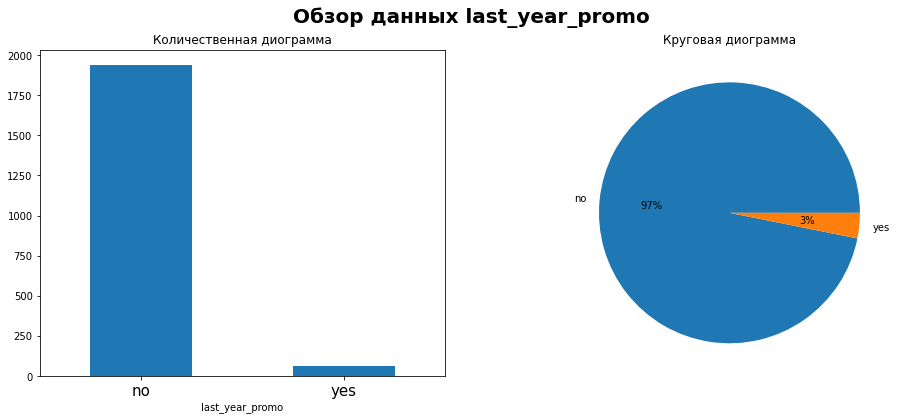

In [35]:
#Построим график для датасета X_test
bar_pie_plot(X_test, 'last_year_promo')

#### last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год

In [36]:
#Выведем общую информацую для датасета train
describe_column(train,'last_year_violations')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count     4000
unique       2
top         no
freq      3441
Name: last_year_violations, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
no     3441
yes     559
Name: last_year_violations, dtype: int64
*****************************************************************************************************************************


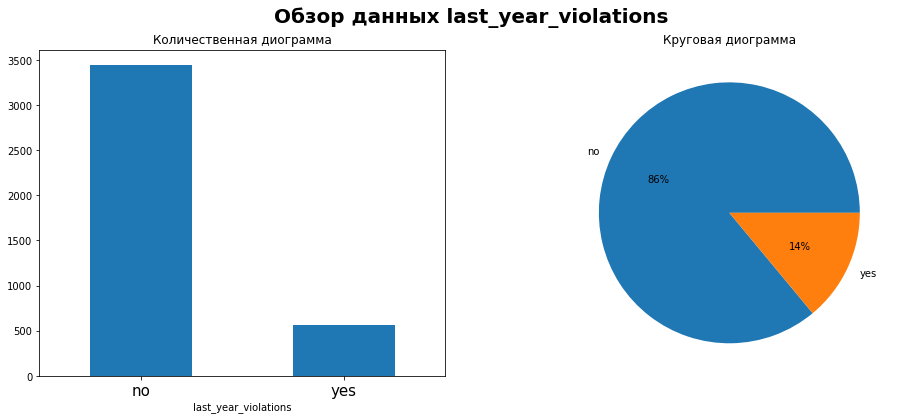

In [37]:
#Построим график для датасета train
bar_pie_plot(train, 'last_year_violations')

In [38]:
#Выведем общую информацую для датасета X_test
describe_column(X_test,'last_year_violations')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
no     1738
yes     262
Name: last_year_violations, dtype: int64
*****************************************************************************************************************************


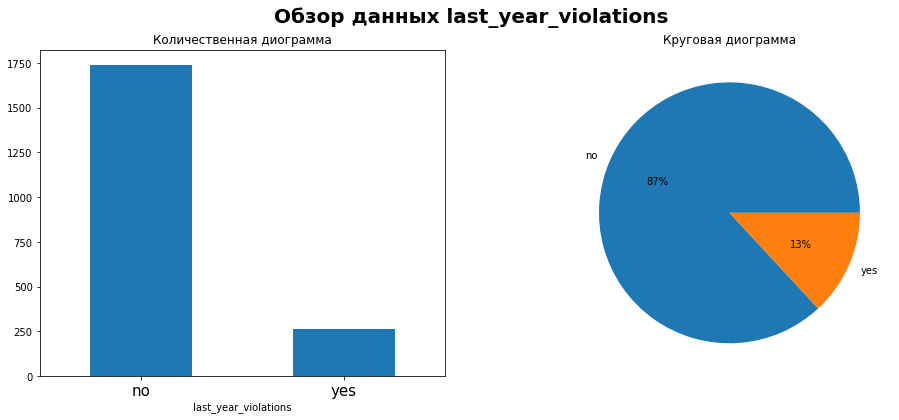

In [39]:
#Построим график для датасета X_test
bar_pie_plot(X_test, 'last_year_violations')

#### supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель

In [40]:
#Выведем общую информацую для датасета train
describe_column(train,'supervisor_evaluation')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 5
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


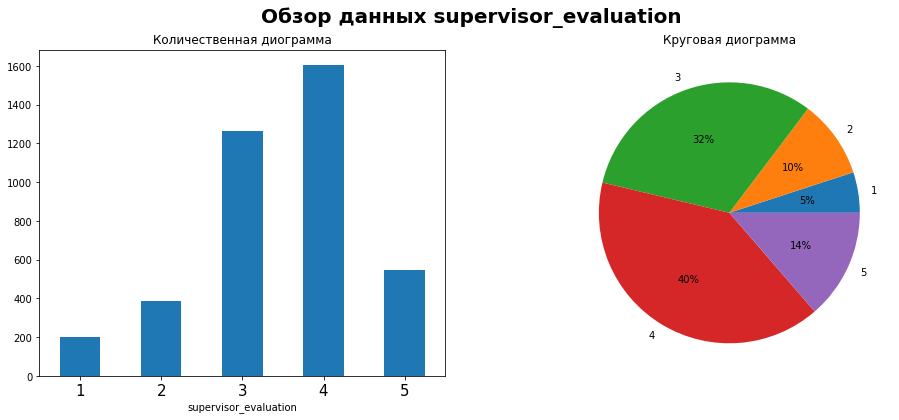

In [41]:
#Построим график для датасета train
bar_pie_plot(train, 'supervisor_evaluation')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


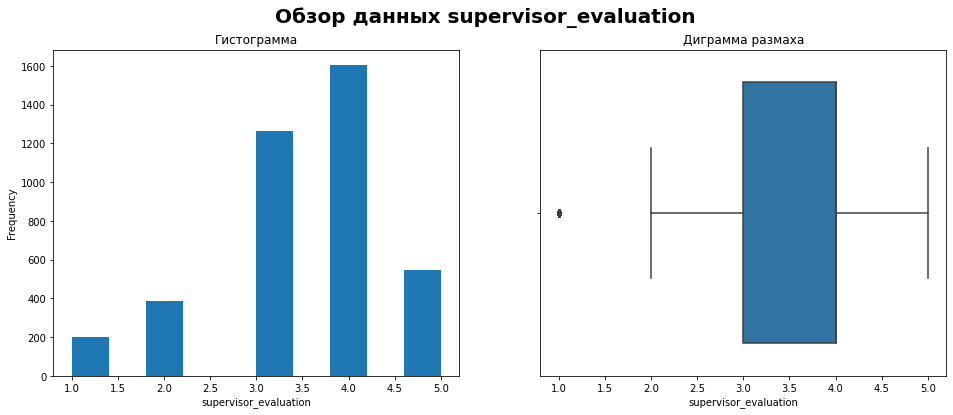

In [42]:
#Построим графики для датасета train
hix_box_plot(train,'supervisor_evaluation')

In [43]:
#Процент выбросов для датасета train
print('Количество выбросов, составляет:', train[train['supervisor_evaluation'] < 2].shape[0])
print('Доля выбросов, составляет:', train[train['supervisor_evaluation'] < 2].shape[0]/train.shape[0])

Количество выбросов, составляет: 201
Доля выбросов, составляет: 0.05025


In [44]:
#Выведем общую информацую для датасета X_test
describe_column(X_test,'supervisor_evaluation')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 5
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


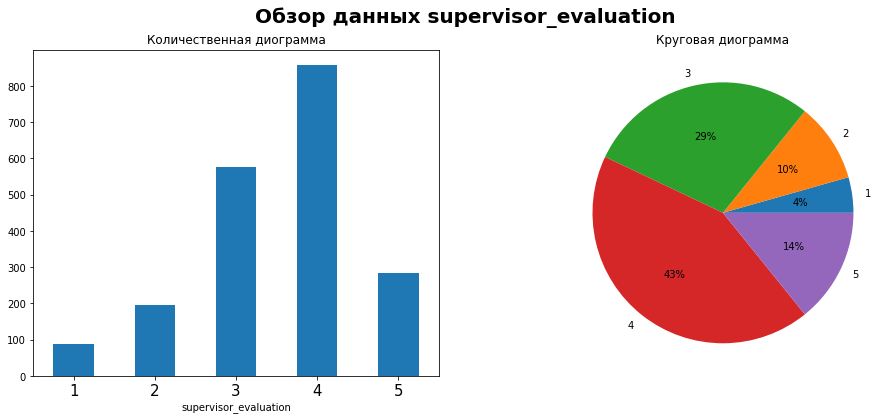

In [45]:
#Построим график для датасета X_test
bar_pie_plot(X_test, 'supervisor_evaluation')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


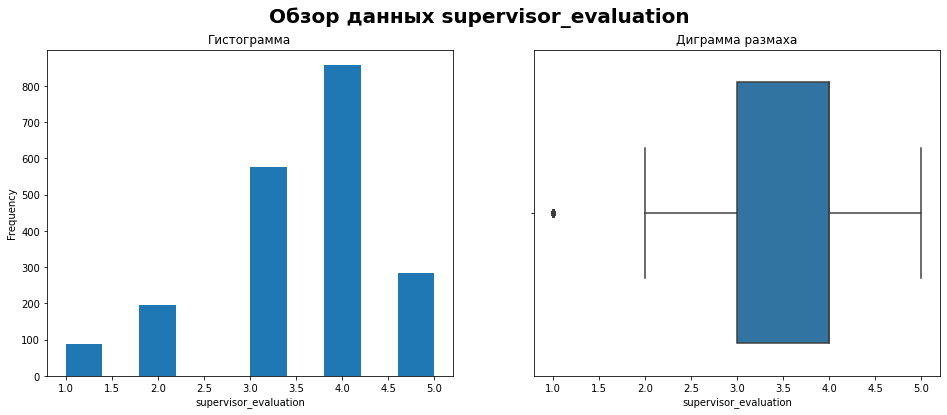

In [46]:
#Построим графики для датасета X_test
hix_box_plot(X_test,'supervisor_evaluation')

In [47]:
#Процент выбросов для датасета X_test
print('Количество выбросов, составляет:', X_test[X_test['supervisor_evaluation'] < 2].shape[0])
print('Доля выбросов, составляет:', X_test[X_test['supervisor_evaluation'] < 2].shape[0]/X_test.shape[0])

Количество выбросов, составляет: 88
Доля выбросов, составляет: 0.044


**Вывод** В столбце supervisor_evaluation — оценка качества работы сотрудника, которую дал руковод. Есть выбросы, но они реалистичны по значениям. На данном этапе удалять их не будем. Процент выбросов составляет не более 5%

#### salary — ежемесячная зарплата сотрудника

In [48]:
#Выведем общую информацую для датасета train
describe_column(train,'salary')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 68
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


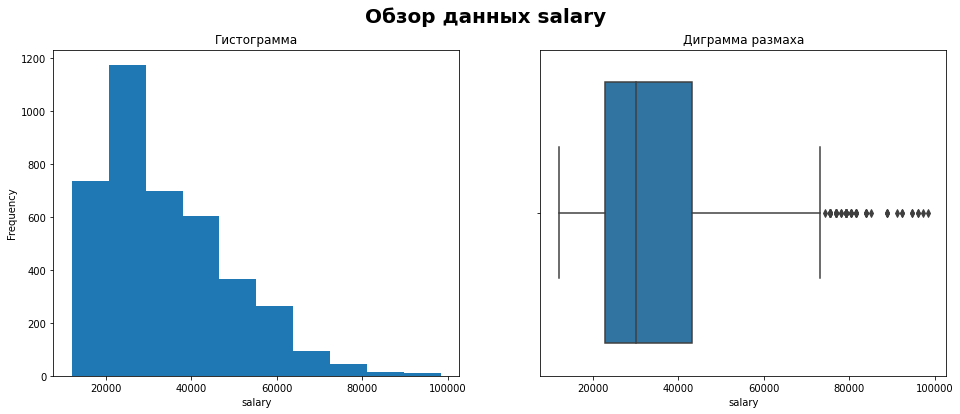

In [49]:
#Построим графики для датасета train
hix_box_plot(train,'salary')

In [50]:
#Процент выбросов для датасета train
print('Количество выбросов, составляет:', train[train['salary'] > 70000].shape[0])
print('Доля выбросов, составляет:', train[train['salary'] > 70000].shape[0]/train.shape[0])

Количество выбросов, составляет: 85
Доля выбросов, составляет: 0.02125


In [51]:
#Выведем общую информацую для датасета X_test
describe_column(X_test,'salary')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 66
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


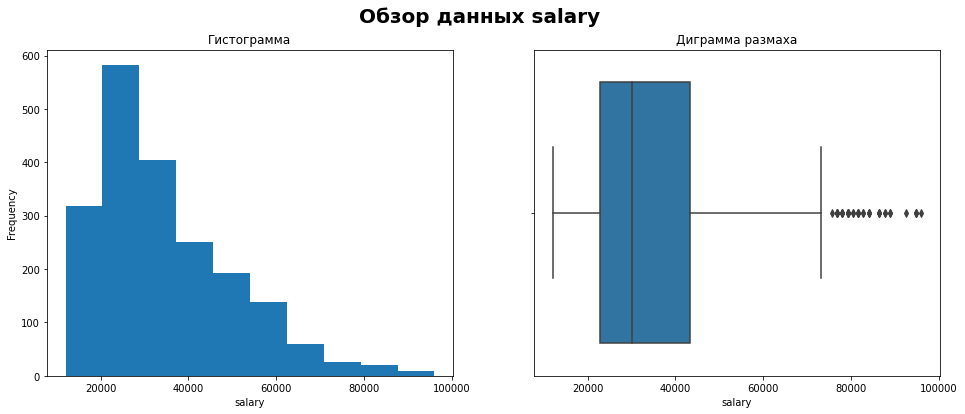

In [52]:
#Построим графики для датасета X_test
hix_box_plot(X_test,'salary')

In [53]:
#Процент выбросов для датасета X_test
print('Количество выбросов, составляет:', X_test[X_test['salary'] > 70000].shape[0])
print('Доля выбросов, составляет:', X_test[X_test['salary'] > 70000].shape[0]/train.shape[0])

Количество выбросов, составляет: 54
Доля выбросов, составляет: 0.0135


**Вывод** В столбце salary — ежемесячная зарплата сотрудника. Есть выбросы, но они реалистичны по значениям. На данном этапе удалять их не будем. Процент выбросов не превышает 2,5%

#### job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [54]:
#Выведем общую информацую для датасета train
describe_column(train,'job_satisfaction_rate')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 98
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


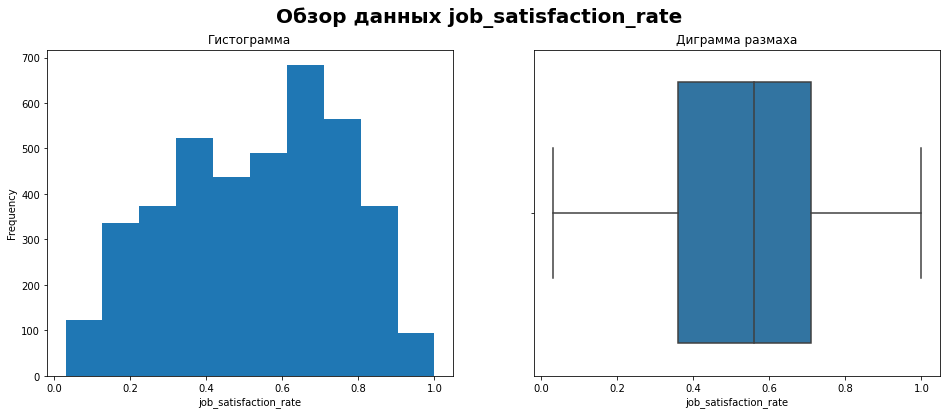

In [55]:
#Построим графики для датасета train
hix_box_plot(train,'job_satisfaction_rate')

In [56]:
#Выведем общую информацую для датасета y_test
describe_column(y_test,'job_satisfaction_rate')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 98
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


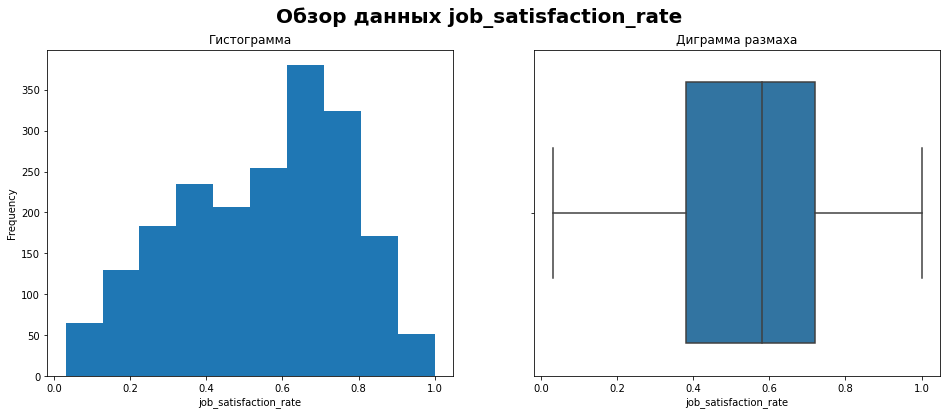

In [57]:
#Построим графики для датасета y_test
hix_box_plot(y_test,'job_satisfaction_rate')

#### Вывод по исследовательскому анализу

Данные в таблицах реалистичны и соответствуют описанию.

В столбцах `dept — отдел, в котором работает сотрудник`, `level — уровень занимаемой должности`, обнаружены пропущенные значения, заполним их на этапе работы с пайплайном.

В данных также обнаружены выбросы в столбцах: `supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель`, ` salary — ежемесячная зарплата сотрудника`. Все выбросы реалистичны по значениям. На данном этапе удалять их не будем.

В датасете X_test в столбцах `dept — отдел, в котором работает сотрудник` и `workload — уровень загруженности сотрудника` обнаружено неожиданное значение ' ', заменили на NaN

В столбце `level — уровень занимаемой должности` исправили опечатку, заменили senior на senior.

###  Корреляционный анализ

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

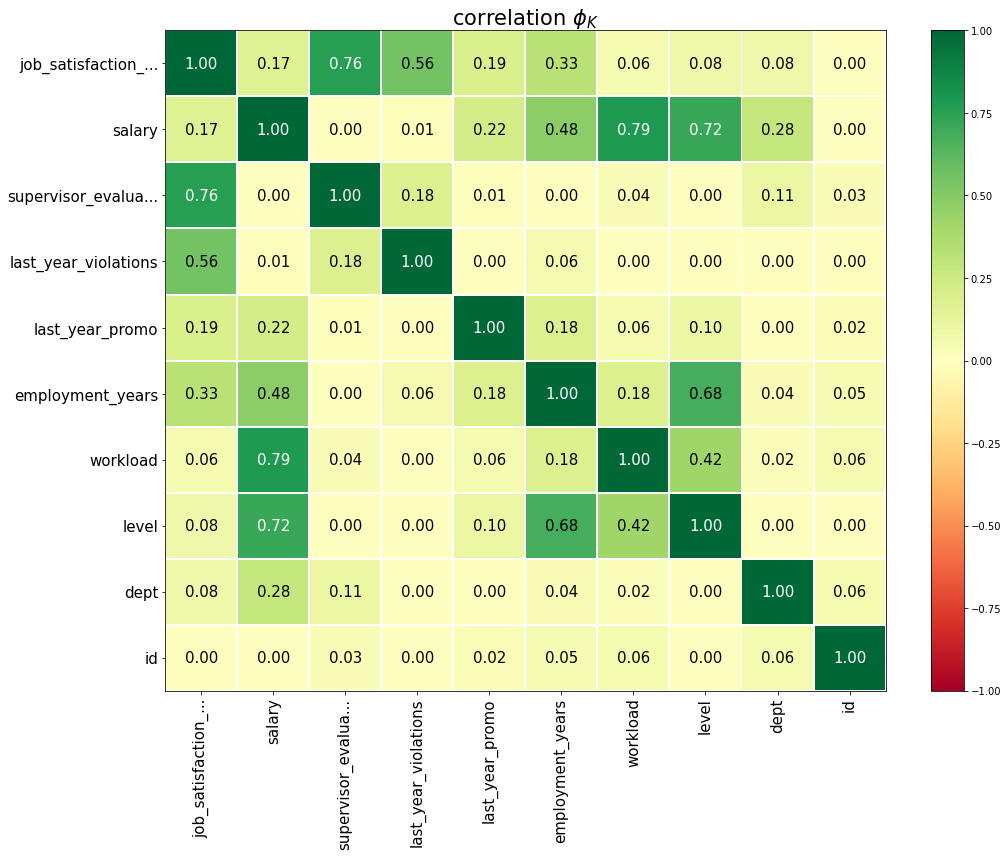

In [58]:
# список численных признаков
interval_cols = train.select_dtypes(include='number').columns.tolist()

# вычисление коэффициентов корреляции phi для датафрейма train
phik_overview = train.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Вывод** 

Из анализа матрицы корреляции видно, что мультиколлинеарности нет. 

При этом целевой признак job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании:
- Сильно коррелирует (0,76) с supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель.
- Значительно коррелирует (0,56) с last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год
- Слабо коррелирует (0,33) employment_years — длительность работы в компании (в годах)

Также прослеживается связь между признаками:
- workload — уровень загруженности сотрудника / salary — ежемесячная зарплата сотрудника (0,79)
- level — уровень занимаемой должности / salary — ежемесячная зарплата сотрудника (0,72)
- level — уровень занимаемой должности / employment_years — длительность работы в компании (в годах) (0,68)
- level — уровень занимаемой должности / workload — уровень загруженности сотрудника (0,42)

Все связи логичны и объяснимы, утечки целевого признака нет. 

### Подготовка данных

In [59]:
# Сделаем id индексом, проверим на дубликаты
train = train.set_index('id')
print('Количество явных дубликатов в датафрейте:', train.duplicated().sum())

Количество явных дубликатов в датафрейте: 245


In [60]:
train = train.drop_duplicates()
train.shape

(3755, 9)

In [61]:
#разобьем данные 
X_train = train.drop(['job_satisfaction_rate'], axis=1)
y_train = train['job_satisfaction_rate']

X_train.shape

(3755, 8)

In [62]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

### Метрика SMAPE 

In [63]:
# создаём функцию для расчёта точности предсказаний каждого класса smape
# «симметричное среднее абсолютное процентное отклонение»
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2))

# создаем метрику
smape_scorer = make_scorer(smape, greater_is_better=False)

### Использование пайплайнов

In [64]:
#создание константы RANDOM_STATE
RANDOM_STATE = 42

In [65]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )


In [66]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


In [67]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)


так как у нас задача предсказать непрерывный числовой признак, то будем использовать DecisionTreeRegressor и LinearRegression

In [68]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [69]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [70]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                   param_distributions=[{'models': [DecisionTreeRegressor(max_depth=13,
                                                                          max_features=8,
                                                                          random_state=42)],
                                         'models__max_depth': range(2, 15),
                                         'models__max_features': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False))

In [71]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [72]:
#Предскажем на изначальных датасетах
X_test_1 = X_test.set_index('id')
y_test_1 = y_test['job_satisfaction_rate']
y_pred_1 = randomized_search.best_estimator_.predict(X_test)
print(f'Значение метрики SMAPE на тестовых данных: {smape(y_test_1, y_pred_1)}')

Значение метрики SMAPE на тестовых данных: 49.9116917294989


Видим, что результат на тестовых данных очень плохой. Расстраиваться не будем, возможно данные в таблицах X_test и y_test расположены в разном порядке. Объединим датасеты X_test и y_test, чтобы данные встали в одном порядке и снова разделим на X_test и y_test

In [73]:
#Объеденим датасеты X_test и y_test
test = X_test.merge(y_test,on='id')

In [74]:
# снова разделим на X_test и y_test
X_test_2 = test.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test_2 = test['job_satisfaction_rate']

In [75]:
#Предскажем на отсортированном датасете
y_pred_2 = randomized_search.best_estimator_.predict(X_test_2)
print(f'Значение метрики SMAPE на тестовых данных: {smape(y_test_2, y_pred_2)}')

Значение метрики SMAPE на тестовых данных: 14.380135080572849


Действительно данные были по разному отсортированы, и после того как мы их упорядочили новая метрика не превышает 15, как и было в условии задачи.

In [76]:
# Создадим итоговый датафрейм со всеми моделями
results_dataframe = pd.DataFrame(randomized_search.cv_results_)
display(results_dataframe)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025224,0.001703,0.015857,0.011915,StandardScaler(),6,14,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-16.329810,-16.153758,-17.156946,-16.316033,-16.373914,-16.466092,0.353389,5
1,0.022015,0.000471,0.008604,0.000301,passthrough,8,13,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-15.603368,-14.696399,-16.800870,-16.577536,-15.833927,-15.902420,0.749881,1
2,0.023244,0.000294,0.009819,0.000300,MinMaxScaler(),4,14,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': MinMaxScaler(), 'models_...",-17.686695,-16.381274,-16.543279,-17.932576,-16.083584,-16.925481,0.740907,6
3,0.020597,0.001033,0.008641,0.000358,passthrough,3,13,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-16.941408,-17.416451,-18.254644,-18.035955,-18.739614,-17.877614,0.632364,7
4,0.021148,0.000264,0.008720,0.000381,passthrough,7,11,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-15.773461,-15.041729,-16.726629,-16.397474,-15.950458,-15.977950,0.575431,3
5,0.022899,0.002157,0.010008,0.000657,MinMaxScaler(),7,3,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': MinMaxScaler(), 'models_...",-23.624882,-22.477697,-24.512662,-23.647491,-21.648790,-23.182304,1.003021,10
6,0.024262,0.002763,0.010391,0.001696,MinMaxScaler(),5,10,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': MinMaxScaler(), 'models_...",-18.538870,-17.826585,-18.064686,-18.442829,-16.941508,-17.962896,0.571709,8
7,0.023217,0.001952,0.010045,0.000691,MinMaxScaler(),14,3,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': MinMaxScaler(), 'models_...",-23.227282,-21.992240,-23.706003,-22.693204,-21.839966,-22.691739,0.711387,9
8,0.027959,0.001998,0.010381,0.000691,StandardScaler(),14,14,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': StandardScaler(), 'model...",-15.451606,-15.084858,-16.917987,-16.415560,-15.801422,-15.934286,0.659007,2
9,0.021845,0.000518,0.008429,0.000053,passthrough,13,10,"DecisionTreeRegressor(max_depth=13, max_featur...","{'preprocessor__num': 'passthrough', 'models__...",-16.299821,-14.976313,-16.720149,-17.809751,-16.203899,-16.401987,0.912716,4


Лучшая модель:
- DecisionTreeRegressor(max_depth=13, max_features=8, random_state=42)
- Метрика лучшей модели на тренировочной выборке: -15.90
- Значение метрики SMAPE на тестовых данных: 14.38

max_depth=13: это параметр, ограничивающий максимальную глубину дерева. Установка глубины в 13 означает, что модель будет строить деревья с максимум 13 уровнями. Это помогает контролировать сложность модели и предотвращать переобучение.

max_features=8: этот параметр определяет максимальное количество признаков, которые могут быть рассмотрены при поиске лучшего разделения узла. Установка этого параметра в 8 означает, что при каждом разделении узла модель будет учитывать не более 8 признаков. Это также помогает управлять сложностью модели.

random_state=42: этот параметр гарантирует воспроизводимость результата моделирования.

### Вывод по первой задачи

**Задача 1**

 Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

---

**Исходные данные**  

Тренировочная выборка: `train_job_satisfaction_rate.csv`

Входные признаки тестовой выборки: `test_features.csv`

Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

- **id** — уникальный идентификатор сотрудника;
- **dept** — отдел, в котором работает сотрудник;
- **level** — уровень занимаемой должности;
- **workload** — уровень загруженности сотрудника;
- **employment_years** — длительность работы в компании (в годах);
- **last_year_promo** — показывает, было ли повышение за последний год;
- **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
- **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
- **salary** — ежемесячная зарплата сотрудника;
- **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

---

**На этапе предобработки данных и исследовательского анализа:** Убедились, что данные в таблицах реалистичны и соответствуют описанию.

В столбцах `dept — отдел, в котором работает сотрудник`, `level — уровень занимаемой должности`, обнаружены пропущенные значения, заполнили их на этапе работы с пайплайном.

В данных также обнаружены выбросы в столбцах: `supervisor_evaluation — оценка качества работы сотрудника`, которую дал руководитель, `salary — ежемесячная зарплата сотрудника`. Все выбросы реалистичны по значениям. На данном этапе удалять их не стали.

В датасете X_test в столбцах `dept — отдел, в котором работает сотрудник` и `workload — уровень загруженности сотрудника обнаружено неожиданное значение` ' ', заменили на NaN

В столбце `level — уровень занимаемой должности` исправили опечатку, заменили senior на senior.

---


**Корреляционный анализ**

Из анализа матрицы корреляции видно, что мультиколлинеарности нет.

При этом целевой признак job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании:

- Сильно коррелирует (0,76) с supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель.
- Значительно коррелирует (0,56) с last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год
- Слабо коррелирует (0,33) employment_years — длительность работы в компании (в годах)

Также прослеживается связь между признаками:

- workload — уровень загруженности сотрудника / salary — ежемесячная зарплата сотрудника (0,79)
- level — уровень занимаемой должности / salary — ежемесячная зарплата сотрудника (0,72)
- level — уровень занимаемой должности / employment_years — длительность работы в компании (в годах) (0,68)
- level — уровень занимаемой должности / workload — уровень загруженности сотрудника (0,42)
- Все связи логичны и объяснимы, утечки целевого признака нет.

---

**Использование пайплайнов**

Для поиска лучшей модели:

- была проведена подготовка данных 
- в качестве моделей рассматривались: DecisionTreeRegressor() и LinearRegression()
- для модели DecisionTreeRegressor был подобраны гиперпараметры
- для перебора моделей и параметров использовали метод RandomizedSearchCV
- в качестве метрики оценки модели была определена метрика smape

Лучшей моделью оказалась:

- DecisionTreeRegressor(max_depth=13, max_features=8, random_state=42)
- Метрика лучшей модели на тренировочной выборке: -15.90
- Значение метрики SMAPE на тестовых данных: 14.38

max_depth=13: это параметр, ограничивающий максимальную глубину дерева. Установка глубины в 13 означает, что модель будет строить деревья с максимум 13 уровнями. Это помогает контролировать сложность модели и предотвращать переобучение.

max_features=8: этот параметр определяет максимальное количество признаков, которые могут быть рассмотрены при поиске лучшего разделения узла. Установка этого параметра в 8 означает, что при каждом разделении узла модель будет учитывать не более 8 признаков. Это также помогает управлять сложностью модели.

random_state=42: этот параметр гарантирует воспроизводимость результата моделирования.

## Задача 2. Предсказать, что сотрудник уволится из компании.

### Загрузка данных

In [77]:
train_2 = pd.read_csv('/datasets/train_quit.csv')
y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')
# так как входные признаки тестовой выборки те же, что и в прошлой задаче, скопируем датасет
X_test_2 = X_test.copy(deep=True)

### Предобработка данных

In [78]:
#Вызовем функцию для датасета 'train'
describe_df(train_2, 'train_2')

размер датафрейма train_2 : (4000, 10)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма train_2


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма train_2


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no
3999,853842,sales,junior,medium,2,no,no,3,27600,yes


_____________________________________________________________________________________________________________________________
Информация о датафрейме train_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
_______________________________________________________________________

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте train_2 : 0
Количество пропусков в датафрейте train_2 : 
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
*****************************************************************************************************************************


In [79]:
#Вызовем функцию для датасета 'X_test_2'
describe_df(X_test_2, 'X_test_2')

размер датафрейма X_test_2 : (2000, 9)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма X_test_2


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма X_test_2


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400


_____________________________________________________________________________________________________________________________
Информация о датафрейме X_test_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
__________________________________________________________________________________________________________________________

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте X_test_2 : 0
Количество пропусков в датафрейте X_test_2 : 
 id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
*****************************************************************************************************************************


In [80]:
#Вызовем функцию для датасета 'y_test_2'
describe_df(y_test_2, 'y_test_2')

размер датафрейма y_test_2 : (2000, 2)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма y_test_2


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма y_test_2


,id,quit
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no
1999,460332,yes


_____________________________________________________________________________________________________________________________
Информация о датафрейме y_test_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
_____________________________________________________________________________________________________________________________
Описание датафрейма y_test_2


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте y_test_2 : 0
Количество пропусков в датафрейте y_test_2 : 
 id      0
quit    0
dtype: int64
*****************************************************************************************************************************


#### Вывод по предобработке данных

Данные в таблицах реалистичны и соответствуют описанию. В тренировочной выборке 4000 строк, в тестовой 2000.

На этапе предобработке данных проверили, что в данных:

- нет дубликатов
- типы столбцов указаны верно
- Название столбцов корректны
- Обнаружены пропущенные значения, заполним их в пайплайне на следующем этапе.

### Исследовательский анализ данных

Исследовательский анализ проведем только для тренировочной выборки и целевого признака. анализ тестовой выборки был проведен на прошлом шаге.

#### id — уникальный идентификатор сотрудника

In [81]:
#Для датасета train
train_2['id'].unique().shape[0]

4000

**Вывод.** Все id уникальны.

#### dept — отдел, в котором работает сотрудник

In [82]:
#Выведем общую информацую для датасета train_2
describe_column(train_2,'dept')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count      4000
unique        5
top       sales
freq       1438
Name: dept, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 5
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64
*****************************************************************************************************************************


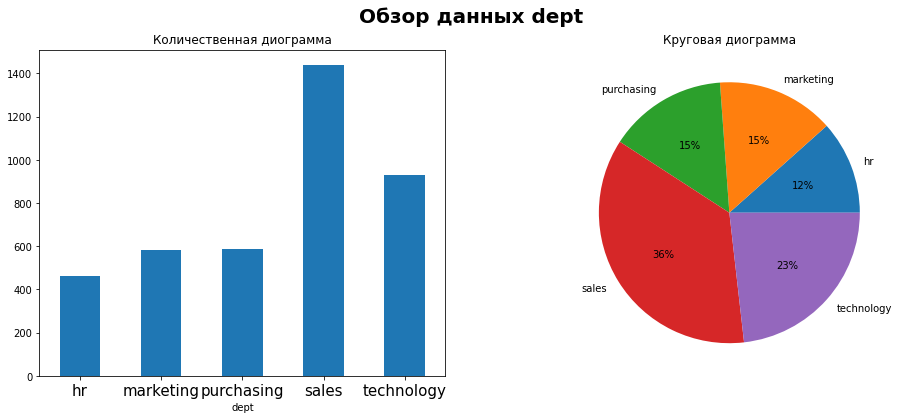

In [83]:
#Построим график для датасета train_2
bar_pie_plot(train_2, 'dept')

#### level — уровень занимаемой должности

In [84]:
#Выведем общую информацую для датасета train_2
describe_column(train_2,'level')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count       4000
unique         3
top       junior
freq        1949
Name: level, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 3
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
junior    1949
middle    1694
sinior     357
Name: level, dtype: int64
*****************************************************************************************************************************


In [85]:
# Заменим опечатку в senior
train_2['level'] = train_2['level'].replace('sinior', 'senior')

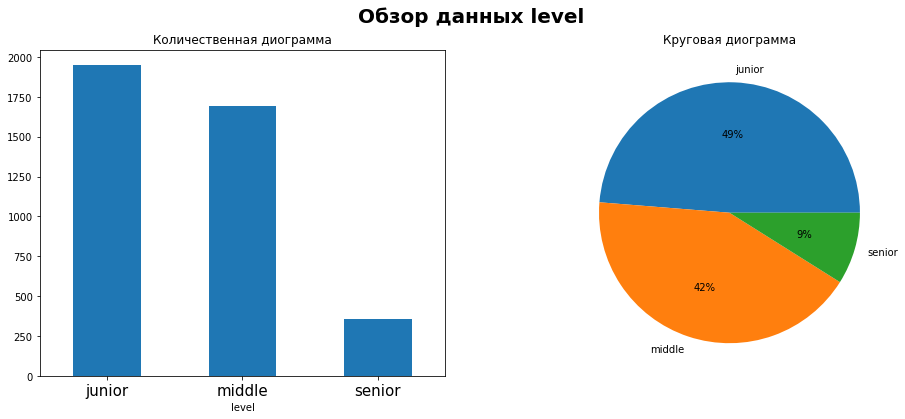

In [86]:
#Построим график для датасета train
bar_pie_plot(train_2, 'level')

#### workload — уровень загруженности сотрудника

In [87]:
#Выведем общую информацую для датасета train_2
describe_column(train_2,'workload')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count       4000
unique         3
top       medium
freq        2118
Name: workload, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 3
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
medium    2118
low       1208
high       674
Name: workload, dtype: int64
*****************************************************************************************************************************


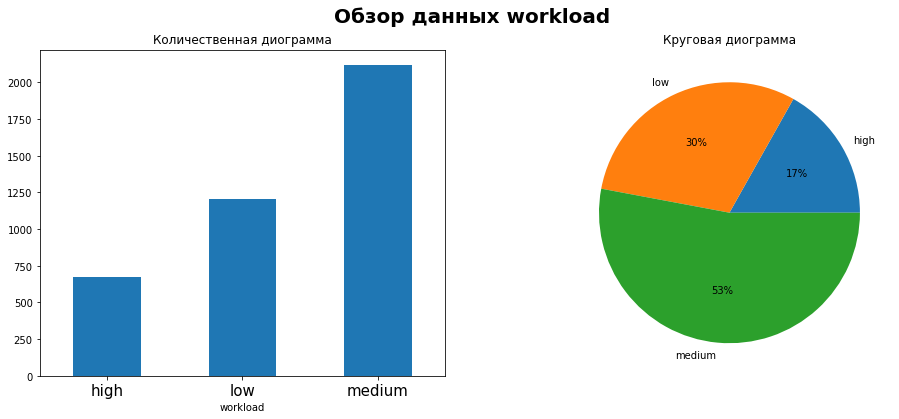

In [88]:
#Построим график для датасета train_2
bar_pie_plot(train_2, 'workload')

#### employment_years — длительность работы в компании (в годах)

In [89]:
#Выведем общую информацую для датасета train_2
describe_column(train_2,'employment_years')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 10
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


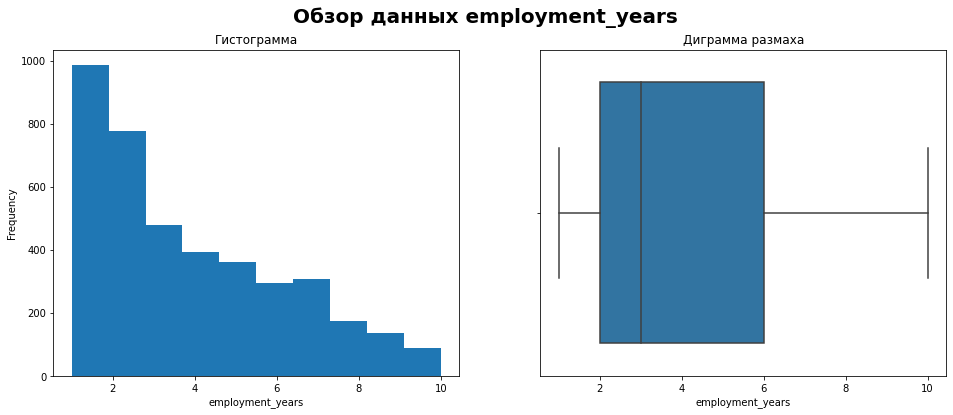

In [90]:
#Построим графики для датасета train_2
hix_box_plot(train_2,'employment_years')

#### last_year_promo — показывает, было ли повышение за последний год

In [91]:
#Выведем общую информацую для датасета train_2
describe_column(train_2,'last_year_promo')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count     4000
unique       2
top         no
freq      3887
Name: last_year_promo, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
no     3887
yes     113
Name: last_year_promo, dtype: int64
*****************************************************************************************************************************


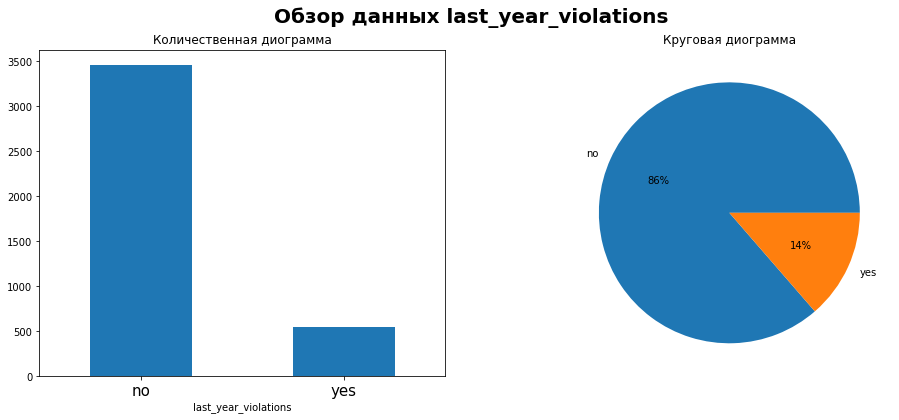

In [92]:
#Построим график для датасета train_2
bar_pie_plot(train_2, 'last_year_violations')

#### last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год

In [93]:
#Выведем общую информацую для датасета train_2
describe_column(train_2,'last_year_violations')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count     4000
unique       2
top         no
freq      3455
Name: last_year_violations, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
no     3455
yes     545
Name: last_year_violations, dtype: int64
*****************************************************************************************************************************


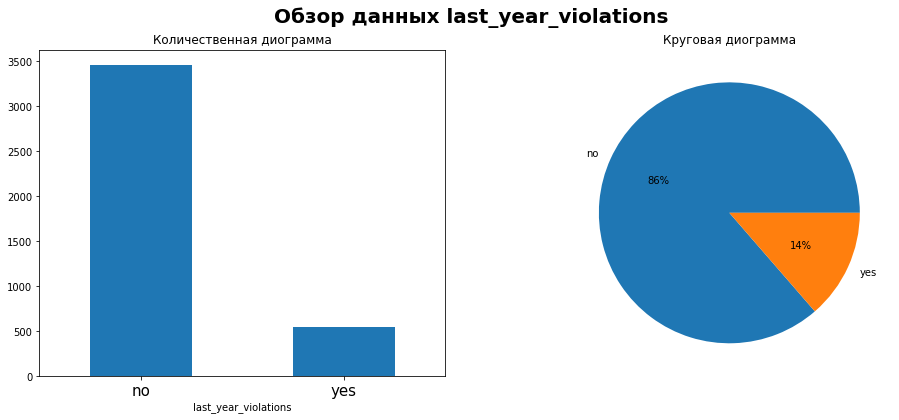

In [94]:
#Построим график для датасета train_2
bar_pie_plot(train_2, 'last_year_violations')

#### supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель

In [95]:
#Выведем общую информацую для датасета train_2
describe_column(train_2,'supervisor_evaluation')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 5
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


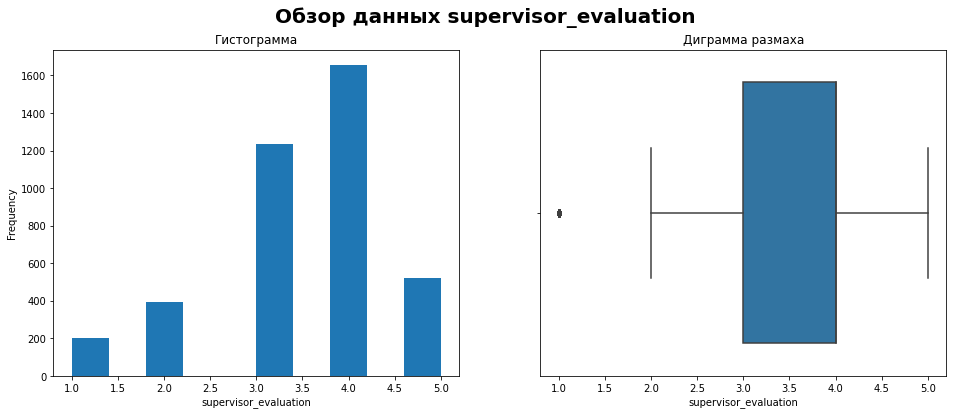

In [96]:
#Построим графики для датасета train_2
hix_box_plot(train_2,'supervisor_evaluation')

In [97]:
#Процент выбросов для датасета train_2
print('Количество выбросов, составляет:', train_2[train_2['supervisor_evaluation'] < 2].shape[0])
print('Доля выбросов, составляет:', train_2[train_2['supervisor_evaluation'] < 2].shape[0]/train_2.shape[0])

Количество выбросов, составляет: 202
Доля выбросов, составляет: 0.0505


**Вывод** В столбце supervisor_evaluation — оценка качества работы сотрудника, которую дал руковод. Есть выбросы, но они реалистичны по значениям. На данном этапе удалять их не будем. Процент выбросов составляет не более 5%

#### salary — ежемесячная зарплата сотрудника

In [98]:
#Выведем общую информацую для датасета train_2
describe_column(train_2,'salary')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 69
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


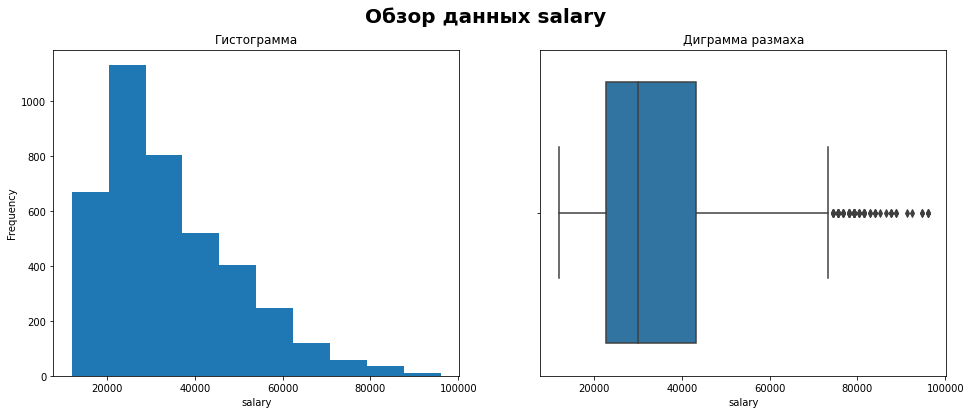

In [99]:
#Построим графики для датасета train_2
hix_box_plot(train_2,'salary')

In [100]:
#Процент выбросов для датасета train_2
print('Количество выбросов, составляет:', train_2[train_2['salary'] > 70000].shape[0])
print('Доля выбросов, составляет:', train_2[train_2['salary'] > 70000].shape[0]/train_2.shape[0])

Количество выбросов, составляет: 104
Доля выбросов, составляет: 0.026


**Вывод** В столбце salary — ежемесячная зарплата сотрудника. Есть выбросы, но они реалистичны по значениям. На данном этапе удалять их не будем. Процент выбросов не превышает 2,5%

#### quit — увольнение сотрудника из компании

In [101]:
#Выведем общую информацую для датасета train_2
describe_column(train_2,'quit')

Количество строк : 4000
_____________________________________________________________________________________________________________________________
Описание данных


count     4000
unique       2
top         no
freq      2872
Name: quit, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
no     2872
yes    1128
Name: quit, dtype: int64
*****************************************************************************************************************************


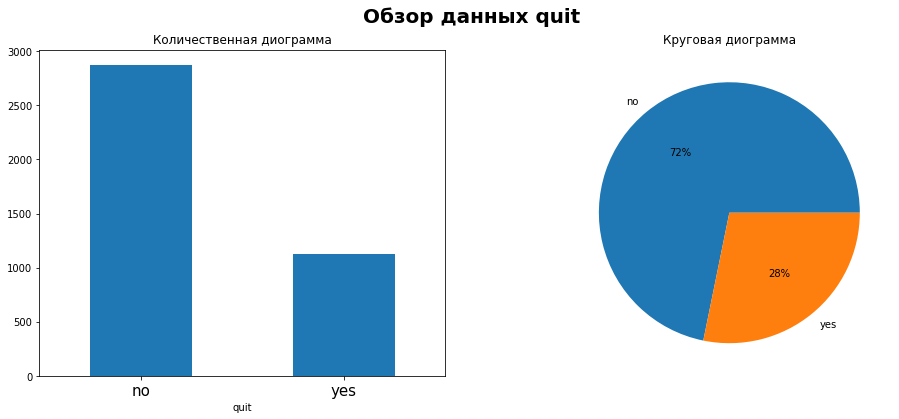

In [102]:
#Построим график для датасета train_2
bar_pie_plot(train_2, 'quit')

In [103]:
#Выведем общую информацую для датасета y_test_2
describe_column(y_test_2,'quit')

Количество строк : 2000
_____________________________________________________________________________________________________________________________
Описание данных


count     2000
unique       2
top         no
freq      1436
Name: quit, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
no     1436
yes     564
Name: quit, dtype: int64
*****************************************************************************************************************************


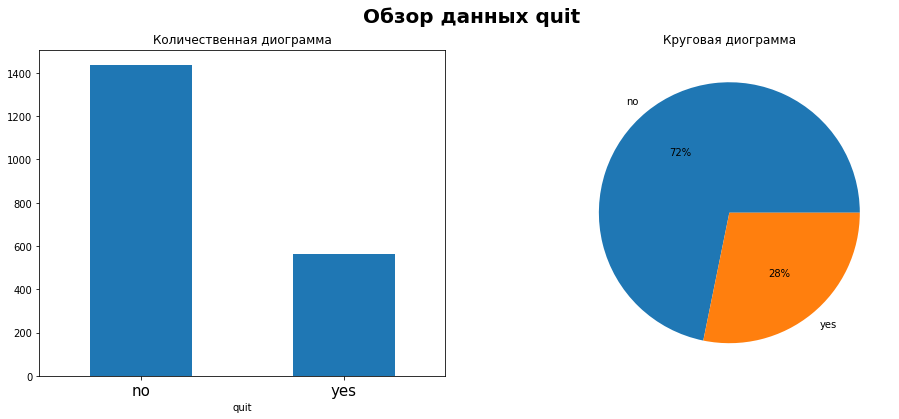

In [104]:
#Построим график для датасета y_test_2
bar_pie_plot(y_test_2, 'quit')

#### Вывод по исследовательскому анализу

Данные в таблицах реалистичны и соответствуют описанию.

В тренировочных данных и в целевом признаке пропущенных значений нет. 

В столбцах: `supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель`, ` salary — ежемесячная зарплата сотрудника` обнаружены выбросы. Все выбросы реалистичны по значениям. На данном этапе удалять их не будем.

В столбце `level — уровень занимаемой должности` исправили опечатку, заменили senior на senior.

### Корреляционный анализ

В связи с тем, что не все признаки распределены нормально, для корреляционного анализа используем матрицу Phik, которая устойчива к ненормальному распределению, позволяет учитывать нелинейные зависимости и работает с различными типами признаков

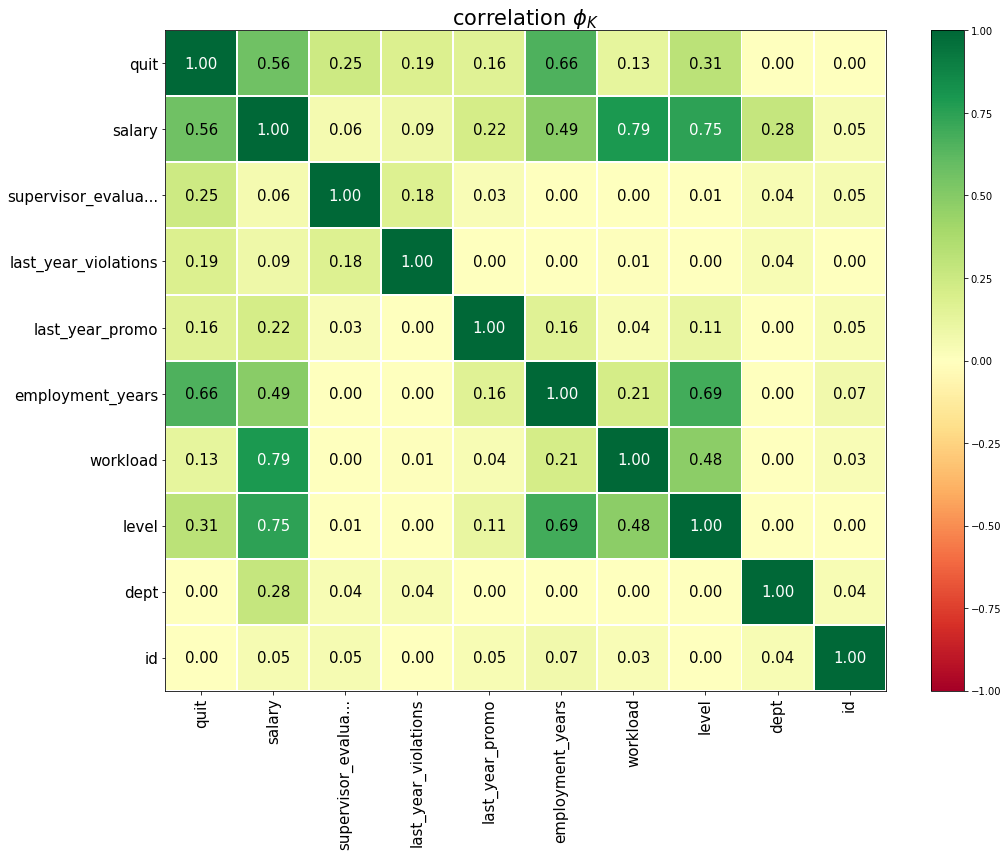

In [105]:
# список численных признаков
interval_cols = train_2.select_dtypes(include='number').columns.tolist()

# вычисление коэффициентов корреляции phi для датафрейма train
phik_overview = train_2.phik_matrix(interval_cols=interval_cols)


# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Вывод** 

Из анализа матрицы корреляции видно, что мультиколлинеарности нет. 

При этом целевой признак quit — увольнение сотрудника из компании:
- Значительно коррелирует (0,66) с employment_years — длительность работы в компании (в годах)
- Значительно коррелирует (0,56) с salary — ежемесячная зарплата сотрудника
- Слабо коррелирует (0,31) c level — уровень занимаемой должности 

Также прослеживается связь между признаками:
- workload — уровень загруженности сотрудника / salary — ежемесячная зарплата сотрудника (0,79)
- level — уровень занимаемой должности / salary — ежемесячная зарплата сотрудника (0,75)
- level — уровень занимаемой должности / employment_years — длительность работы в компании (в годах) (0,69)
- level — уровень занимаемой должности / workload — уровень загруженности сотрудника (0,48)

Все связи логичны и объяснимы, утечки целевого признака нет. 

### Портрет «уволившегося сотрудника»

*Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.*

Для удобства оценки зарплаты ушедших сотрудников выделем 5 сегментов: до 20 тыс, 20-40 тыс, 40-60 тыс, 60-80 тыс, от 80 тыс.

In [106]:
# Функция расчета зарплаты
def salary_level(value):
    if value >= 80000:
            return "от 80к"
    elif value < 80000 and value >= 60000:
            return "60-80к"
    elif value < 60000 and value >= 40000:
            return "40-60к"
    elif value < 40000 and value >= 20000:
            return "20-40к"
    elif value < 20000:
            return "до 20к"    
 

In [107]:
#добавим столбец с уровнем зарплаты
train_2['salary_level'] = train_2['salary'].apply(salary_level)
train_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,salary_level
0,723290,sales,middle,high,2,no,no,4,54000,no,40-60к
1,814010,sales,junior,medium,2,no,no,4,27600,no,20-40к
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,20-40к
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,20-40к
4,910140,marketing,junior,medium,2,no,no,5,25200,no,20-40к


In [108]:
#Зададим параметры для анализа
categorical_variables = train_2.select_dtypes(exclude='number').columns.tolist()
categorical_variables.extend(['supervisor_evaluation','employment_years'])
categorical_variables.remove('quit')
categorical_variables

['dept',
 'level',
 'workload',
 'last_year_promo',
 'last_year_violations',
 'salary_level',
 'supervisor_evaluation',
 'employment_years']

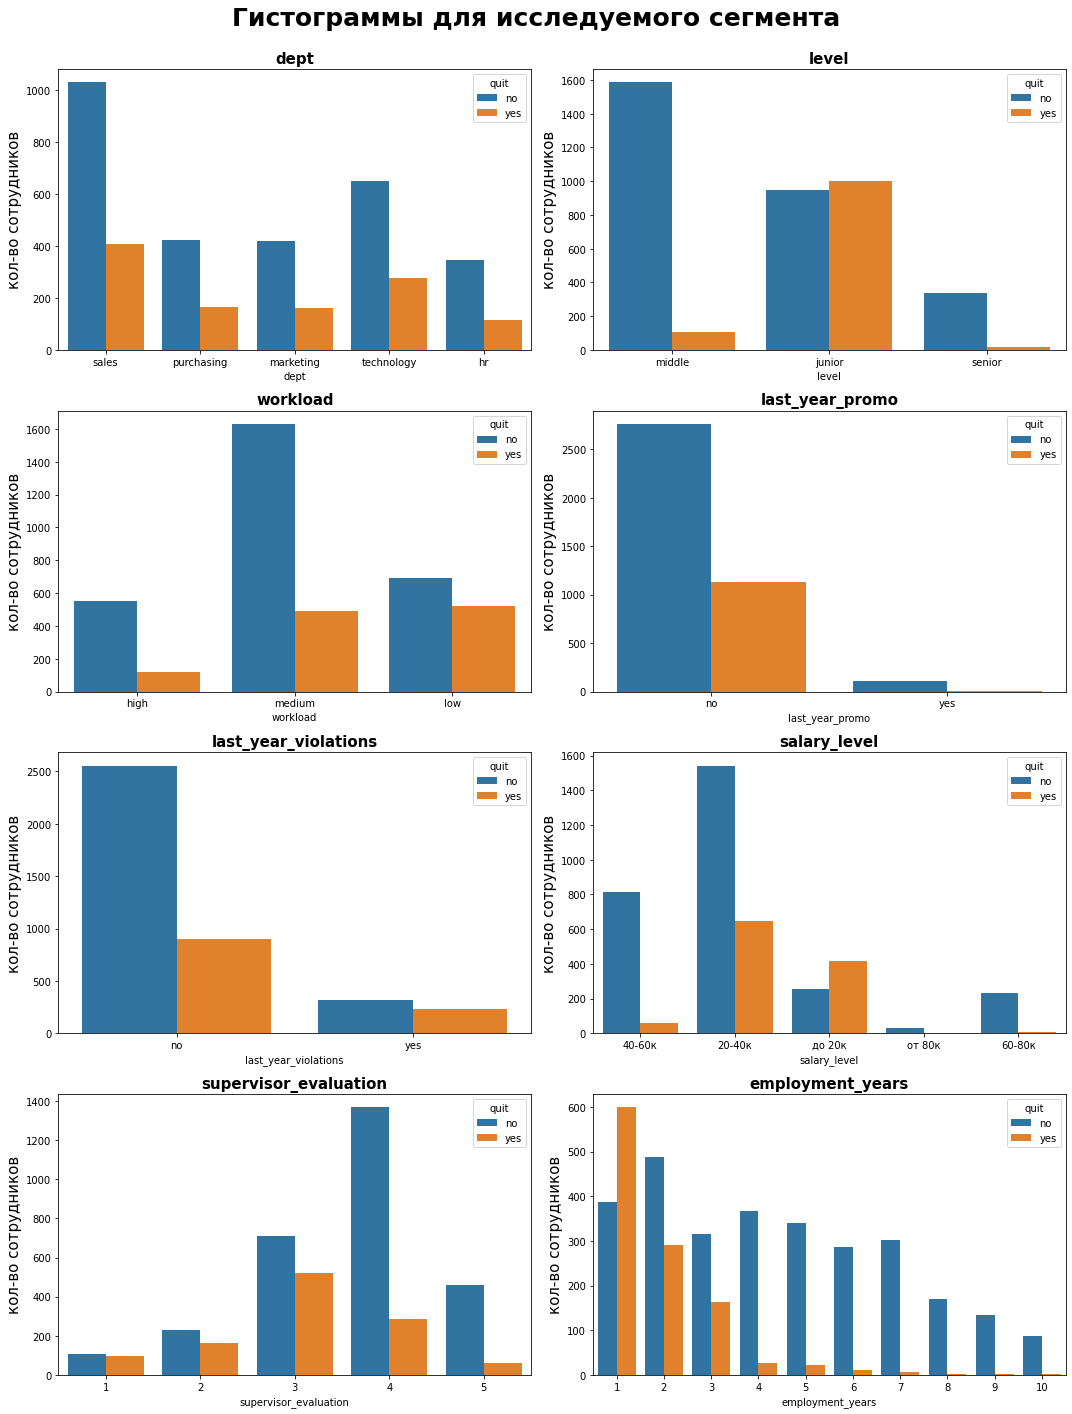

In [109]:
#Построим графики соотношения уволившихся сотрудников к работающим в абсолютных значениях
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,20))
fig.suptitle(f'Гистограммы для исследуемого сегмента\n', fontsize = 25, fontweight='bold')

temp = 1
for i in categorical_variables:
    plt.subplot(4, 2, temp)
    sns.countplot(x = i, data = train_2, hue = 'quit')
    temp += 1
    plt.title(f'{i}', fontsize = 15, fontweight='bold')
#    plt.xlabel(i, fontsize = 15)
    plt.ylabel('кол-во сотрудников', fontsize = 15)

plt.tight_layout()

In [110]:
# В процентном соотношении
for i in categorical_variables:
    
    for j in train_2[i].unique():        
        print('Процент уволившихся сотрудников', i, j, round(train_2[(train_2[i] == j) & (train_2['quit'] == 'yes')]\
                         .shape[0]/(train_2[(train_2[i] == j)].shape[0])*100,2), '%')
    print('*' * 125)

Процент уволившихся сотрудников dept sales 28.3 %
Процент уволившихся сотрудников dept purchasing 28.23 %
Процент уволившихся сотрудников dept marketing 28.01 %
Процент уволившихся сотрудников dept technology 29.74 %
Процент уволившихся сотрудников dept hr 25.0 %
*****************************************************************************************************************************
Процент уволившихся сотрудников level middle 6.38 %
Процент уволившихся сотрудников level junior 51.46 %
Процент уволившихся сотрудников level senior 4.76 %
*****************************************************************************************************************************
Процент уволившихся сотрудников workload high 17.95 %
Процент уволившихся сотрудников workload medium 23.04 %
Процент уволившихся сотрудников workload low 42.96 %
*****************************************************************************************************************************
Процент уволившихся сотрудников last_y

Подведем итоги:

`dept — отдел, в котором работает сотрудник` 

Если смотреть в абсолютных величинах, то большинство уволившихся сотрудников работало в отделе продаж, но если сравнивать относительные показатели то самый большой процент уволившихся сотрудников в отделе technology (29.74 %). Хотя в отделах purchasing, sales, marketing процент уволившихся сотрудников варьируется от 28-29%

`level — уровень занимаемой должности`

Больше всего сотрудников увольняется с позиции junior, что логично. Сотрудник приобрел нужные знания и навыки и пошел и уже искать вакансии на позицию middle.  

` workload — уровень загруженности сотрудника` 

Если смотреть в абсолютных величинах, то количество уволившихся сотрудников с загруженностью medium и low примерно одинаково, но если сравнивать относительные показатели то самый большой процент уволившихся сотрудников с уровнем загруженности low (42,96%), в то время когда medium (23,04%)

`employment_years — длительность работы в компании (в годах)` 

Больше всего сотрудников увольняется в первый год работы (60,81%), во второй и третий год увольняются 37,32% и 34,03% соответственно. Доля увольнений, среди тех кто проработал в компании более трех лет значительно ниже.

` last_year_promo — показывает, было ли повышение за последний год`

Процент увольнений среди сотрудников у кого не было повышение составляет 28,99%, и 0,88% среди тех кого повысили.

` last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год`

Если смотреть в абсолютных величинах, то большинство уволившихся сотрудников работало не нарушали трудовой договор за последний год, но если сравнивать относительные показатели то среди тех кто нарушал трудовой договор за последний год уволившихся 41,83%, кто не нарушал 26,05%

`salary_level - уровень зарплаты`

Если смотреть в абсолютных величинах, то большинство уволившихся сотрудников получали от 20-40к, но если сравнивать относительные показатели то самый большой процент уволившихся сотрудников среди тех, кто получал до 20к (61,94%), среди тех, кто получал от 20-40к процент уволившихся сотрудников составляет (29,52%). Среди сотрудников, чья зарплата превышает 80к увольнений нет.

**Из вышеперечисленного, можно вывести портрет уволившегося сотрудника:** Специалист на позиции junior, отработавший в компании менее двух лет, с уровень загруженности - low и зарплатой менее 40к. 


### распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников

*Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.*

При анализе будем использовать данные с обоими целевыми признаками тестовой выборки.

In [111]:
full_test = test.merge(y_test_2, on='id')
full_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


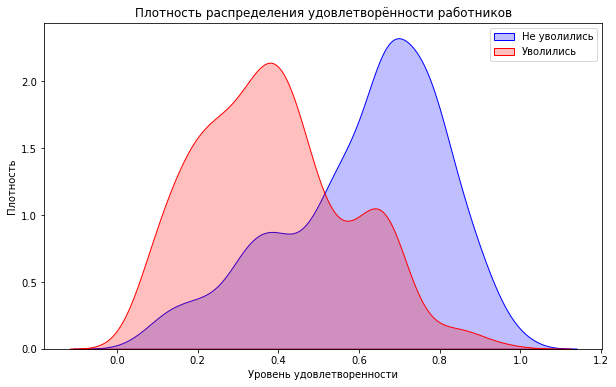

In [112]:
#Разобьем данные по признаку признака job_satisfaction_rate для ушедших и оставшихся сотрудников.
full_test_no_quit = full_test[full_test['quit'] == 'no']['job_satisfaction_rate']
full_test_yes_quit = full_test[full_test['quit'] == 'yes']['job_satisfaction_rate']

#Пострим распределение 
plt.figure(figsize=(10, 6))
sns.kdeplot(full_test_no_quit, fill=True, color='blue', label='Не уволились')
sns.kdeplot(full_test_yes_quit, fill=True, color='red', label='Уволились')
plt.title('Плотность распределения удовлетворённости работников')
plt.xlabel('Уровень удовлетворенности')
plt.ylabel('Плотность')
plt.legend()
plt.show()

**Вывод** Из графика видно, что чем выше уровень удовлетворенности сотрудника, тем больше вероятность, что сотрудник не уволится. И наоборот - чем ниже удовлетворенность - тем повышаются риски увольнения сотрудника.

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

Сформулируем гипотезы:

Нулевая гипотеза: Среднее значение удовлетворённости сотрудника работой в компании у уволившихся и оставшихся равно

Альтернативная гипотеза: Среднее значение удовлетворённости сотрудника работой в компании у уволившихся меньше чем у оставшихся 

In [113]:
#Зададим уровень статистической значимости
alpha = 0.05

# так как у нас правосторонняя альтернативная гипотеза используем параметр 'greater'
results = st.ttest_ind(full_test[full_test['quit'] == 'no']['job_satisfaction_rate'],
                       full_test[full_test['quit'] == 'yes']['job_satisfaction_rate'], 
                       alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 6.155610332585965e-105
Отвергаем нулевую гипотезу


In [114]:
#Сравним среднее значение удовлетворённости сотрудника работой 
print('Среднее значение удовлетворённости уволившегося сотрудника:', full_test[full_test['quit'] == 'yes']\
      ['job_satisfaction_rate'].mean().round(2))
print('Среднее значение удовлетворённости работающего сотрудника:', full_test[full_test['quit'] == 'no']\
      ['job_satisfaction_rate'].mean().round(2))

Среднее значение удовлетворённости уволившегося сотрудника: 0.39
Среднее значение удовлетворённости работающего сотрудника: 0.61


**Вывод** Среднее значение удовлетворённости уволившегося сотрудника ниже. чем у того кто остался работать в компании

### Добавление нового входного признака

In [115]:
# добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.
train_2['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(train_2.drop(['quit'], axis=1))
train_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,salary_level,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,40-60к,0.646765
1,814010,sales,junior,medium,2,no,no,4,27600,no,20-40к,0.851538
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,20-40к,0.357500
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,20-40к,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,20-40к,0.690000


In [116]:
X_test_2['job_satisfaction_rate_pred'] = randomized_search.best_estimator_.predict(X_test_2)
X_test_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.866364
1,686555,hr,junior,medium,1,no,no,4,30000,0.670417
2,467458,sales,middle,low,5,no,no,4,19200,0.654000
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.832000


**Вывод** добавили job_satisfaction_rate к тренировочным и тестовым данным второй задачи.

### Подготовка данных

In [117]:
# Сделаем id индексом, проверим на дубликаты
train_2 = train_2.set_index('id')
print('Количество явных дубликатов в датафрейте:', train_2.duplicated().sum())

Количество явных дубликатов в датафрейте: 1413


In [118]:
#Удалим дубликаты
train_2 = train_2.drop_duplicates()
train_2.shape

(2587, 11)

In [119]:
#разобьем данные 
X_train_2 = train_2.drop(['quit', 'salary_level'], axis=1)
y_train_2 = train_2['quit']

X_train_2.shape

(2587, 9)

In [120]:
#Объеденим датасеты X_test_2 и X_test_2
test_2 = X_test_2.merge(y_test_2,on='id')

# снова разделим на X_test_2 и X_test_2
X_test_2 = test_2.drop(['id', 'quit'], axis=1)
y_test_2 = test_2['quit']

X_test_2.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,marketing,junior,medium,2,no,no,5,28800,0.866364


In [121]:
# закодируем целевой признак
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

In [122]:
# создаём списки с названиями признаков
ohe_columns_2 = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns_2 = ['level', 'workload']
num_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

### Использование пайплайнов

Кодирование переменных было определено на предыдущем шаге

In [123]:
# создаём общий пайплайн для подготовки данных

data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns_2),
        ('ord', ord_pipe, ord_columns_2),
        ('num', MinMaxScaler(), num_columns_2)
    ], 
    remainder='passthrough'
)

так как у нас задача предсказать категориальный признак, то будем использовать DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, CVС

In [124]:
# создаём итоговый пайплайн: подготовка данных и модель

pipeline_final = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [125]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,15),
        'models__max_features': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели CVС()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__kernel': ['linear', 'rbf']
    }
    
       
]

In [126]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [127]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

In [128]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_proba_2 = randomized_search.predict_proba(X_test_2)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2, y_test_proba_2)}')

Метрика ROC-AUC на тестовой выборке: 0.9136712499259172


In [129]:
# Создадим итоговый датафрейм со всеми моделями
results_dataframe = pd.DataFrame(randomized_search.cv_results_)
display(results_dataframe)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023108,0.002569,0.010148,0.000141,StandardScaler(),11,7,"DecisionTreeClassifier(max_depth=5, max_featur...",NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.864686,0.877545,0.850364,0.865852,0.905916,0.872873,0.018637,6
1,0.017687,0.000339,0.008421,0.000233,passthrough,6,5,"DecisionTreeClassifier(max_depth=5, max_featur...",NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.898532,0.895905,0.891508,0.884399,0.907658,0.895600,0.007698,3
2,0.018126,0.000376,0.008486,0.000204,passthrough,12,5,"DecisionTreeClassifier(max_depth=5, max_featur...",NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.905911,0.908320,0.887029,0.912074,0.909337,0.904534,0.008973,1
3,0.019956,0.000484,0.009885,0.000502,MinMaxScaler(),5,8,"DecisionTreeClassifier(max_depth=5, max_featur...",NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.898090,0.864214,0.840387,0.865892,0.907479,0.875212,0.024434,5
4,0.020761,0.000440,0.010645,0.000798,StandardScaler(),4,4,"DecisionTreeClassifier(max_depth=5, max_featur...",NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.860928,0.867163,0.852757,0.859194,0.858642,0.859737,0.004621,7
5,0.022081,0.000717,0.010148,0.000281,MinMaxScaler(),10,11,"DecisionTreeClassifier(max_depth=5, max_featur...",NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.757056,0.809023,0.791134,0.791442,0.809848,0.791701,0.019131,9
6,0.020604,0.000994,0.010456,0.000361,StandardScaler(),4,2,"DecisionTreeClassifier(max_depth=5, max_featur...",NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.831312,0.841897,0.830677,0.841400,0.837496,0.836556,0.004795,8
7,0.019609,0.001968,0.009700,0.001156,passthrough,4,14,"DecisionTreeClassifier(max_depth=5, max_featur...",NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.738214,0.769742,0.793023,0.777002,0.813690,0.778334,0.025104,10
8,0.027132,0.005702,0.010112,0.000175,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=...",1,"{'preprocessor__num': StandardScaler(), 'model...",0.918796,0.890090,0.893842,0.896479,0.913771,0.902595,0.011470,2
9,0.018816,0.000145,0.009466,0.000056,MinMaxScaler(),7,3,"DecisionTreeClassifier(max_depth=5, max_featur...",NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.885176,0.887307,0.892497,0.889279,0.864638,0.883780,0.009869,4


Лучшая модель:
- DecisionTreeClassifier(max_depth=5, max_features=12, random_state=42)
- Метрика лучшей модели на тренировочной выборке: 0.9045342688175939
- Метрика ROC-AUC на тестовой выборке: : 0.9136712499259172

max_depth=5: это параметр, ограничивающий максимальную глубину дерева. Установка глубины в 5 означает, что модель будет строить деревья с максимум 5 уровнями. Это помогает контролировать сложность модели и предотвращать переобучение.

max_features=12: этот параметр определяет максимальное количество признаков, которые могут быть рассмотрены при поиске лучшего разделения узла. Установка этого параметра в 12 означает, что при каждом разделении узла модель будет учитывать не более 12 признаков. Это также помогает управлять сложностью модели.

random_state=42: этот параметр гарантирует воспроизводимость результата моделирования.

### Вывод по второй задачи

**Задача 1**

Построить модель, которая сможет предсказать, что сотрудник уволится из компании. 

---

**Исходные данные**  

Тренировочная выборка: `train_quit.csv`

Входные признаки тестовой выборки: `test_features.csv`

Целевой признак тестовой выборки: `test_target_quit.csv`

- **id** — уникальный идентификатор сотрудника;
- **dept** — отдел, в котором работает сотрудник;
- **level** — уровень занимаемой должности;
- **workload** — уровень загруженности сотрудника;
- **employment_years** — длительность работы в компании (в годах);
- **last_year_promo** — показывает, было ли повышение за последний год;
- **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
- **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
- **salary** — ежемесячная зарплата сотрудника;
- **quit** — уволился ли сотрудник, целевой признак.

---

**На этапе предобработки данных и исследовательского анализа:** Убедились, что данные в таблицах реалистичны и соответствуют описанию.

Данные тестовой выборки были проанализированны и исправлены опечатки на этапе работы с первой задачи.

В тренировочных данных и в целевом признаке пропущенных значений нет. 

В столбцах: `supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель`, ` salary — ежемесячная зарплата сотрудника` обнаружены выбросы. Все выбросы реалистичны по значениям. На данном этапе удалять их не будем.

В столбце `level — уровень занимаемой должности` исправили опечатку, заменили senior на senior.

---


**Корреляционный анализ**

Из анализа матрицы корреляции видно, что мультиколлинеарности нет. 

При этом целевой признак quit — увольнение сотрудника из компании:
- Значительно коррелирует (0,66) с employment_years — длительность работы в компании (в годах)
- Значительно коррелирует (0,56) с salary — ежемесячная зарплата сотрудника
- Слабо коррелирует (0,31) c level — уровень занимаемой должности 

Также прослеживается связь между признаками:
- workload — уровень загруженности сотрудника / salary — ежемесячная зарплата сотрудника (0,79)
- level — уровень занимаемой должности / salary — ежемесячная зарплата сотрудника (0,75)
- level — уровень занимаемой должности / employment_years — длительность работы в компании (в годах) (0,69)
- level — уровень занимаемой должности / workload — уровень загруженности сотрудника (0,48)

Все связи логичны и объяснимы, утечки целевого признака нет. 

---

**Анализ уволившихся сотрудников**

Провели анализ данных по целевому признаку и вывели портрет уволившегося сотрудника: Специалист на позиции junior, отработавший в компании менее двух лет, с уровень загруженности - low и зарплатой менее 40к.

Построили график плотности распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников и убедились, что чем выше уровень удовлетворенности сотрудника, тем больше вероятность, что сотрудник не уволится. И наоборот - чем ниже удовлетворенность - тем повышаются риски увольнения сотрудника.

---

**Использование пайплайнов**

Для поиска лучшей модели:

- была проведена подготовка данных 
- в качестве моделей рассматривались: DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression(), CVС()
- для моделей были подобраны гиперпараметры
- для перебора моделей и параметров использовали метод RandomizedSearchCV
- в качестве метрики оценки модели была выбрана - ROC-AUC.

Лучшая модель:

- DecisionTreeClassifier(max_depth=5, max_features=12, random_state=42)
- Метрика лучшей модели на тренировочной выборке: 0.9045342688175939
- Метрика ROC-AUC на тестовой выборке: : 0.9136712499259172

max_depth=5: это параметр, ограничивающий максимальную глубину дерева. Установка глубины в 5 означает, что модель будет строить деревья с максимум 5 уровнями. Это помогает контролировать сложность модели и предотвращать переобучение.

max_features=12: этот параметр определяет максимальное количество признаков, которые могут быть рассмотрены при поиске лучшего разделения узла. Установка этого параметра в 12 означает, что при каждом разделении узла модель будет учитывать не более 12 признаков. Это также помогает управлять сложностью модели.

random_state=42: этот параметр гарантирует воспроизводимость результата моделирования.

## Общий вывод

**Описание проекта**. HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

---

**Цель исследования** Исследование уровня удовлетворённости сотрудника, чтобы предсказать отток сотрудников.

---

**Задачи исследования**

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

---

**Исходные данные 1 задачи**

Тренировочная выборка: `train_job_satisfaction_rate.csv`

Входные признаки тестовой выборки: `test_features.csv`

Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

**Исходные данные 2 задачи**  

Тренировочная выборка: `train_quit.csv`

Входные признаки тестовой выборки: `test_features.csv`

Целевой признак тестовой выборки: `test_target_quit.csv`
    
---

**На этапе предобработки данных и исследовательского анализа:** Убедились, что данные в таблицах реалистичны и соответствуют описанию. Исправили опечатки, обнаруженные пропущенные значения заполнили на этапе работы с пайплайном. 

---

**Корреляционный анализ**

Построили матрицы корреляции убедились, что мультиколлинеарности нет. 

Все связи логичны и объяснимы, утечки целевого признака нет. 

---

**Анализ уволившихся сотрудников**

Провели анализ данных по целевому признаку и вывели портрет уволившегося сотрудника: Специалист на позиции junior, отработавший в компании менее двух лет, с уровень загруженности - low и зарплатой менее 40к.

Построили график плотности распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников и убедились, что чем выше уровень удовлетворенности сотрудника, тем больше вероятность, что сотрудник не уволится. И наоборот - чем ниже удовлетворенность - тем повышаются риски увольнения сотрудника.

---

**Использование пайплайнов**

`Для поиска лучшей модели для задачи 1:`

- была проведена подготовка данных 
- в качестве моделей рассматривались: DecisionTreeRegressor() и LinearRegression()
- для модели DecisionTreeRegressor был подобраны гиперпараметры
- для перебора моделей и параметров использовали метод RandomizedSearchCV
- в качестве метрики оценки модели была определена метрика smape

Лучшей моделью оказалась:

- DecisionTreeRegressor(max_depth=13, max_features=8, random_state=42)
- Метрика лучшей модели на тренировочной выборке: -15.90
- Значение метрики SMAPE на тестовых данных: 14.38

max_depth=13: это параметр, ограничивающий максимальную глубину дерева. Установка глубины в 13 означает, что модель будет строить деревья с максимум 13 уровнями. Это помогает контролировать сложность модели и предотвращать переобучение.

max_features=8: этот параметр определяет максимальное количество признаков, которые могут быть рассмотрены при поиске лучшего разделения узла. Установка этого параметра в 8 означает, что при каждом разделении узла модель будет учитывать не более 8 признаков. Это также помогает управлять сложностью модели.

random_state=42: этот параметр гарантирует воспроизводимость результата моделирования.

`Для поиска лучшей модели задачи 2:`

- была проведена подготовка данных 
- в качестве моделей рассматривались: DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression(), CVС()
- для моделей были подобраны гиперпараметры
- для перебора моделей и параметров использовали метод RandomizedSearchCV
- в качестве метрики оценки модели была выбрана - ROC-AUC.

Лучшая модель:

- DecisionTreeClassifier(max_depth=5, max_features=12, random_state=42)
- Метрика лучшей модели на тренировочной выборке: 0.9045342688175939
- Метрика ROC-AUC на тестовой выборке: : 0.9136712499259172

max_depth=5: это параметр, ограничивающий максимальную глубину дерева. Установка глубины в 5 означает, что модель будет строить деревья с максимум 5 уровнями. Это помогает контролировать сложность модели и предотвращать переобучение.

max_features=12: этот параметр определяет максимальное количество признаков, которые могут быть рассмотрены при поиске лучшего разделения узла. Установка этого параметра в 12 означает, что при каждом разделении узла модель будет учитывать не более 12 признаков. Это также помогает управлять сложностью модели.

random_state=42: этот параметр гарантирует воспроизводимость результата моделирования.

---

**Предложения для бизнеса**

Для того, чтобы снизить количество увольнений в компании, можно предложить заказчику следующие рекомендации:

- Разработать план карьерного роста (от junior - до middle - и до senior). Прописать четкие критерии перехода.
- Ввести надбавки к зарплате в зависимости от стажа в компании.
- Создание комфортных условий труда: рабочее место, техническое оснащение, освещенность и уровень шума.
- Эффективное управление загруженностью: правильное распределение задач в команде и контроль над их выполнением
- Привлекать молодых специалистов к новым интересным проектам в компании